<a href="https://colab.research.google.com/github/kridtapon/WFO-New-TrixEFI-Flow/blob/main/WFO_New_TrixEFI_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-29-fe18868eea49>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-fe18868eea49>:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-fe18868eea49>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


Walk-Forward Optimization Results:
   Year Best_Params  Test_Return
0  2020     (8, 22)     1.371227
1  2021     (7, 20)     0.692480
2  2022     (7, 20)     0.291994
3  2023     (5, 20)    -0.073011
4  2024     (7, 20)     1.011026
5  2025     (8, 19)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            979272.77318
Total Return [%]                       879.272773
Benchmark Return [%]                   396.466113
Max Gross Exposure [%]                      100.0
Total Fees Paid                      20131.496044
Max Drawdown [%]                        40.483716
Max Drawdown Duration                       505.0
Total Trades                                   23
Total Closed Trades                            23
Total Open Trades                               0
Open Trade PnL                   

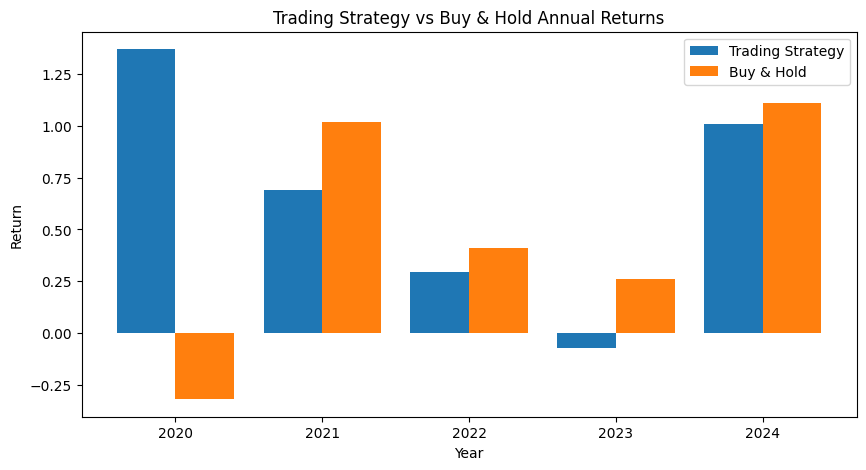

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Trix Indicator (Triple Exponential Moving Average)
def calculate_trix(df, period=14):
    """
    Calculate the Trix Indicator.
    """
    # First, calculate the Exponential Moving Averages (EMA)
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()

    # Trix is the rate of change of the third EMA
    trix = ema3.pct_change() * 100  # Multiply by 100 to express it as a percentage

    return trix

# Function to calculate Elder's Force Index (EFI)
def calculate_efi(df, period=13):
    """
    Calculate Elder's Force Index (EFI).
    """
    efi = (df['Close'] - df['Close'].shift(1)) * df['Volume']
    efi = efi.rolling(window=period).mean()  # Smoothing over the specified period
    return efi

# Walk-forward optimization with Trix and EFI
def walk_forward_optimization_trix_efi(df, start_year, end_year):
    results = []

    # Define dynamic ranges for Trix and EFI periods
    trix_period_range = range(5, 31)  # Range for Trix periods
    efi_period_range = range(5, 31)   # Range for EFI periods

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of Trix and EFI parameters
        for params in itertools.product(trix_period_range, efi_period_range):
            trix_period, efi_period = params

            # Calculate Trix and EFI on the training data
            train_data['Trix'] = calculate_trix(train_data, period=trix_period)
            train_data['EFI'] = calculate_efi(train_data, period=efi_period)

            # Generate entry and exit signals based on Trix and EFI
            entries = (train_data['Trix'] > 0) & (train_data['EFI'] > 0)  # Trix above 0 and EFI positive for entry
            exits = (train_data['Trix'] < 0) & (train_data['EFI'] < 0)    # Trix below 0 and EFI negative for exit

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (trix_period, efi_period)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply Trix and EFI indicators
        yearly_data['Trix'] = calculate_trix(yearly_data, period=best_params[0])
        yearly_data['EFI'] = calculate_efi(yearly_data, period=best_params[1])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['Trix'] > 0) & (yearly_data['EFI'] > 0)  # Trix above 0 and EFI positive for entry
        exits = (yearly_data['Trix'] < 0) & (yearly_data['EFI'] < 0)    # Trix below 0 and EFI negative for exit

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'TRGP'  # NFLX TRGP
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_trix_efi(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply Trix and EFI indicators
    yearly_data['Trix'] = calculate_trix(yearly_data, period=params[0])
    yearly_data['EFI'] = calculate_efi(yearly_data, period=params[1])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['Trix'] > 0) & (yearly_data['EFI'] > 0)
    exits = (yearly_data['Trix'] < 0) & (yearly_data['EFI'] < 0)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [30]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,496466.113474
Total Return [%],396.466113
Benchmark Return [%],396.466113
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],88.453909
